# PROJECT

### The problem

Let us consider the two-dimensional spatial domain  
$$
\Omega = (0,1)^2.
$$  

We want to solve the following **parametrized problem**:  
given  
$$
\mu = (\mu_0, \mu_1) \in \mathcal{P} = [0.1, 1]^2,
$$  
find $u(\mu)$ such that
$$
- \Delta u(\mu) + \frac{\mu_0}{\mu_1} \left( e^{\mu_1 u(\mu)} - 1 \right) = g(x; \mu),
$$  
with **homogeneous Dirichlet boundary conditions** on $\partial\Omega$.

### Part 1

The source term is defined as:  
$$
g(x; \mu) = -2\mu_0(y(y-1)+x(x-1))+\mu_0/\mu_1 \cdot (e^{\mu_1 \mu_0 xy(x-1)(y-1)}-1) \in \Omega.
$$


Exact solution:
$$
u(x,y;\mu)= \mu_0 xy (x-1)(y-1)
$$

### Variational formulation

Let $\Omega = (0,1)^2$ and $V = H_0^1(\Omega)$.  
Given $\mu = (\mu_0, \mu_1) \in [0.1, 1]^2$,  
find $u(\mu) \in V$ such that
$$
\underbrace{\int_{\Omega} \nabla u(\mu) \cdot \nabla v \, dx}_{f_1}
+ \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u(\mu)} v \, dx}_{f_2}
- \underbrace{\frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx}_{f_3}
- \underbrace{\int_{\Omega} g(x; \mu) v \, dx}_{f_4} = 0,
\quad \forall v \in V.
$$

### Legend

- $f_1$: diffusion term -> collegato alla stiffness  
- $f_2$: nonlinear reaction term  
- $f_3$: constant reaction term  
- $f_4$: source term


### Linearized problem: Newton step
NB: C'E' DIPENDENZA DA MU OVUNQUE

At each iteration $k$, given $u^{(k)} \in V$, find the increment $\delta u^{(k)} \in V$ such that:
$$
J_F(u^{(k)},\delta u^{(k)}) \, \delta u^{(k)} = -F(u^{(k)}),
$$.
In our case:
$$
\left( \int_{\Omega} \nabla \delta u^{(k)} \cdot \nabla v \, dx
+ {\mu_0} \int_{\Omega} e^{\mu_1 u^{(k)}} \delta u^{(k)} v \, dx\right) \delta u^{(k)}
= -F(u^{(k)}; v)
\quad \forall v \in V,
$$
where
$$
F(u^{(k)}; v) =
\int_{\Omega} \nabla u^{(k)} \cdot \nabla v \, dx
+ \frac{\mu_0}{\mu_1} \int_{\Omega} e^{\mu_1 u^{(k)}} v \, dx
- \frac{\mu_0}{\mu_1} \int_{\Omega} v \, dx
- \int_{\Omega} g(x; \mu) v \, dx.
$$

Then update:
$$
u^{(k+1)} = u^{(k)} + \delta u^{(k)}.
$$
### Legend: RICORDA, ORA LA MIA VARIABILE E' DELTA_U_K, NON U_K
- $stiffness_a$: riferito a stiffness (primo a sinistra)
- $reaction_b$ : riferito alla reaction
- A DESTRA STESSI NOMI DI PRIMA( QUANDO ASSEMBLI FAI ATTENZIONE AI SEGNI) 
- $f_1$
- $f_2$
- $f_3$
- $f_4$



In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

 ### 1. POD

#### First, find High fidelity
Remember: since a(u,v) is non linear, we use the Newton emthod to solve it.

##### Define the quantities that we need to assemble the matrices

In [4]:
# attenzione: ricordati poi di premoltiplicare per il parametro, se c'è
def Diffusion_a(numPoints, points): # vettore unitario che moltiplica il primo integrale
	values_a = np.ones(numPoints, order='F')
	return values_a.ctypes.data
# vettore unitario che moltiplica il secondo integrale
def Reaction_b(numPoints, points): 
	values_b = np.ones(numPoints, order='F')
	return values_b.ctypes.data
# vettore con exp(mu_1*u) valutato nei punti di quadratura(?)
def Reaction_non_linear_b(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
 # f_1 (è uguale al Lab 12)
def Term_non_linear_der_f_1(numPoints, points, u, u_x, u_y):
	vecu_x = gedim.make_nd_array(u_x, numPoints, np.double)
	vecu_y = gedim.make_nd_array(u_y, numPoints, np.double)
	values_nl_d_f = np.zeros((2, numPoints), order='F')
	values_nl_d_f[0,:] = vecu_x
	values_nl_d_f[1,:] = vecu_y
	return values_nl_d_f.ctypes.data
# f_2
def Term_non_linear_f_2(numPoints, points, u, u_x, u_y): 
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	values_nl_b = np.exp(mu_1*vecu) # nota: abbiamo già elevato alla mu_1 qui
	return values_nl_b.ctypes.data
# f_4 (parte con la g)
def Term_f_4(numPoints, points): 
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values_f = -2*mu_0*(matPoints[1,:]*(matPoints[1,:]-1)+matPoints[0,:]*(matPoints[0,:]-1)) + mu_0/mu_1 * (np.exp(mu_0*mu_1*matPoints[0,:]*matPoints[1,:]*(matPoints[0,:]-1)*(matPoints[1,:]-1))-1)#100 * np.sin(2*np.pi*matPoints[0,:]) * np.cos(2*np.pi*matPoints[1,:])
	return values_f.ctypes.data

def ExactSolution(numPoints, points):
    # Converte i punti in una matrice 3 x numPoints
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    x = matPoints[0, :]
    y = matPoints[1, :]

    # Calcola la soluzione esatta
    u = mu_0*x*(x-1)*y*(y-1)

    return u.ctypes.data

def ExactDerivativeSolution(direction, numPoints, points):
    matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
    x = matPoints[0, :]
    y = matPoints[1, :]
    
    if direction == 0:
    	values_ex_d = (2*x-1)*mu_0*y*(y-1)
    elif direction == 1:
    	values_ex_d = (2*y-1)*mu_0*x*(x-1)
    else:
    	values_ex_d = np.zeros(numPoints, order='F')
    
    return values_ex_d.ctypes.data

def Ones_f_2(numPoints, points): # serve per f_2
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def Ones_f_3(numPoints, points): # serve per f_3
	values_one = np.ones(numPoints, order='F')
	return values_one.ctypes.data
    
def OnesDerivative_f_1(numPoints, points): # serve per f_1
	values_one_d = np.ones((2, numPoints), order='F')
	return values_one_d.ctypes.data
# serve per il calcolo delle norme (tipo ||du|| = ||du-0||
def Zeros(numPoints, points):
	values_zero = np.zeros(numPoints, order='F')
	return values_zero.ctypes.data
# serve per la nroma H1
def ZerosDerivative(direction, numPoints, points):
	values_zero_d = np.zeros(numPoints, order='F')
	return values_zero_d.ctypes.data


##### Define the Mesh size and the order of discretization

In [5]:
meshSize = 0.001
order = 1

##### Create the mesh and plot it

In [6]:
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)

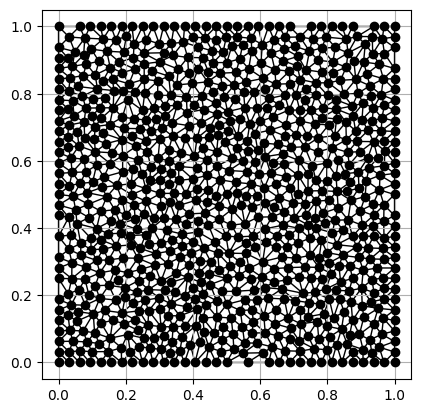

In [7]:
gedim.PlotMesh(mesh)

#### Create Discrete Space FEM and plot the mesh

In [8]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

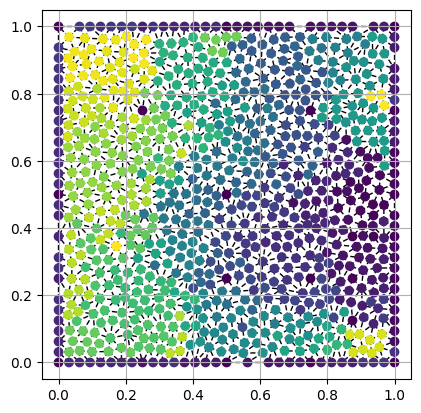

In [9]:
gedim.PlotDofs(mesh, dofs, strongs)

### Newton phase

#### Initial values and Hyperparameters

In [10]:
residual_norm = 1.0  # per farlo entare nel loop
solution_norm = 1.0 #per farlo entarre nel loop
newton_tol = 1.0e-8 #tolleranza relativa
max_iterations = 100 # eventualmente, modifica
num_iteration = 1

In [11]:
# initial guess u
u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
# value on the border (=0) bc homogenous dirichlet
u_strong = np.zeros(problemData['NumberStrongs'], order='F')

In [12]:
np.random.seed(42)  # Imposta il seed per la riproducibilità
mu_set = np.random.uniform(low=0.1, high=1, size=(20, 2))

In [13]:
print("{:<8s} {:<6s} {:>14s} {:>14s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. L2 Err", "Rel. H1 Err", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
))
#Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)


for mu in mu_set:
    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    u_k = np.zeros(problemData['NumberDOFs'], order='F')
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_errorL2 = 5
    u_normL2 = 1
    u_errorH1 = 5
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)

    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        #update u_k
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_errorL2 = gedim.ComputeErrorL2(ExactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(ExactDerivativeSolution, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<14.6e} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            u_errorL2 / u_normL2,
            u_errorH1 / u_normH1,
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1

DOFs     h         Rel. L2 Err    Rel. H1 Err  Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
713      0.064    2.484225e-03   5.133790e-02   1.000000e+00   1      100      mu = (0.437, 0.956)
713      0.064    2.661992e-03   5.134782e-02   2.112618e-04   2      100      mu = (0.437, 0.956)
713      0.064    2.661992e-03   5.134782e-02   1.012332e-11   3      100      mu = (0.437, 0.956)
713      0.064    2.284263e-03   5.132743e-02   1.000000e+00   1      100      mu = (0.759, 0.639)
713      0.064    2.629594e-03   5.134597e-02   4.194274e-04   2      100      mu = (0.759, 0.639)
713      0.064    2.629594e-03   5.134597e-02   7.939969e-11   3      100      mu = (0.759, 0.639)
713      0.064    2.668823e-03   5.134821e-02   1.000000e+00   1      100      mu = (0.240, 0.240)
713      0.064    2.682620e-03   5.134900e-02   1.613885e-05   2      100      mu = (0.240, 0.240)
713      0.064    2.682620e-03   5.134900e-02   4.484575e-15   3      100      mu = (0.240, 0.240)
713      0

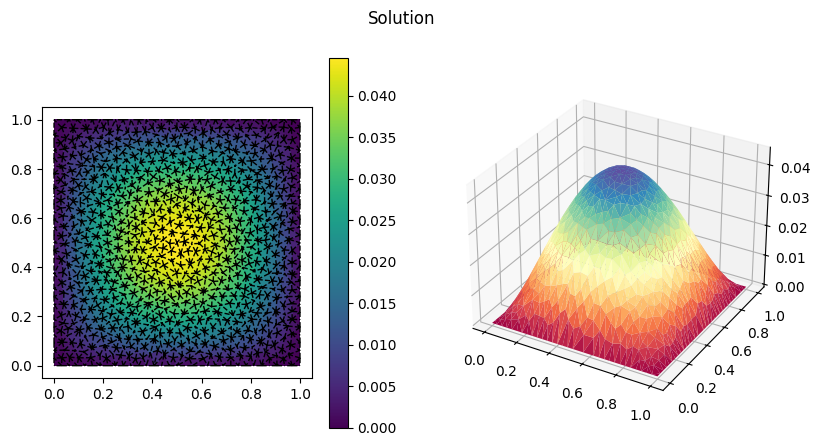

In [14]:
gedim.PlotSolution(mesh, dofs, strongs, u_k, u_strong)
#gedim.ExportSolution(Burger_exactSolution, u_k, u_strong, lib)

[numQuadraturePoints, quadraturePoints, quadratureWeights, sol, sol_x, sol_y] = gedim.EvaluateSolutionOnPoints(u_k, u_strong, lib)
gedim.ExportSolutionOnPoints(numQuadraturePoints, quadraturePoints, sol, lib)

In [26]:
mu = [0.5, 0.3]
dofs_errors = {}

for size in [0.05, 0.03, 0.01, 0.0051, 0.003, 0.001, 0.0005, 0.0001]:
    meshSize = size
    order = 1
    domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
    [meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
    discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2] }
    [problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)
    print("DOFs: ", dofs.shape[1])
    residual_norm = 1.0  # per farlo entare nel loop
    solution_norm = 1.0 #per farlo entarre nel loop
    newton_tol = 1.0e-8 #tolleranza relativa
    max_iterations = 100 # eventualmente, modifica
    num_iteration = 1
    # initial guess u
    u_k = np.zeros(problemData['NumberDOFs'], order='F') # eventualmente modifica: così potrebbe non convergere
    # value on the border (=0) bc homogenous dirichlet
    u_strong = np.zeros(problemData['NumberStrongs'], order='F')
    print("{:<8s} {:<6s} {:>14s} {:>14s} {:>14s} {:>10s} {:>10s} {:>15s}".format(
    "DOFs", "h", "Rel. L2 Err", "Rel. H1 Err", "Rel. Residual", "Iter", "Max Iter", "mu = (μ₀, μ₁)"
    ))
    #Possono stare fuori tutti i temini che non dipendono da termini non lienari (uk) e quindi detro il while loro, e quelli che non dipendono da mu
    [stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Diffusion_a, problemData, lib)
    forcingTerm_f_3 = gedim.AssembleForcingTerm(Ones_f_3, problemData, lib)

    # devo riaggiornare u_k inizale ogni volta, (ma in realtà ha anche senso dargli la soluzione precednte che è buona per avere una convergenza più rapida)
    mu_0 = mu[0]
    mu_1 = mu[1]
    u_errorL2 = 5
    u_normL2 = 1
    u_errorH1 = 5
    u_normH1 = 1
    num_iteration = 1
    residual_norm = 10
    solution_norm = 1.0

    forcingTerm_f_4 = gedim.AssembleForcingTerm(Term_f_4, problemData, lib)

    while num_iteration < max_iterations and residual_norm > newton_tol * solution_norm: 
        [reaction, reactionStrong] = gedim.AssembleNonLinearReactionMatrix(Reaction_b, Reaction_non_linear_b, u_k, u_strong, problemData, lib)

        forcingTerm_der_f_1 = gedim.AssembleNonLinearDerivativeForcingTerm(OnesDerivative_f_1, Term_non_linear_der_f_1, u_k, u_strong, problemData, lib)
        forcingTerm_f_2 = gedim.AssembleNonLinearForcingTerm(Ones_f_2, Term_non_linear_f_2, u_k, u_strong, problemData, lib)

        # define right and left hand sides
        rhs = -forcingTerm_der_f_1 - mu_0/mu_1 * forcingTerm_f_2 + mu_0/mu_1 * forcingTerm_f_3 + forcingTerm_f_4
        lhs = stiffness + mu_0 * reaction
        # solve linear system to find du
        du = gedim.LUSolver(lhs, \
                rhs, \
                lib)
        #update u_k
        u_k = u_k + du
        
        du_normL2 = gedim.ComputeErrorL2(Zeros, du, np.zeros(problemData['NumberStrongs'], order='F'), lib)
        u_normL2 = gedim.ComputeErrorL2(Zeros, u_k, u_strong, lib)
    
        u_errorL2 = gedim.ComputeErrorL2(ExactSolution, u_k, u_strong, lib)
        u_errorH1 = gedim.ComputeErrorH1(ExactDerivativeSolution, u_k, u_strong, lib)
        u_normH1 = gedim.ComputeErrorH1(ZerosDerivative, u_k, u_strong, lib)
        solution_norm =  u_normL2
        residual_norm =  du_normL2
        #print(residual_norm)
        """relative L2 e H1 errore non hann senso qui perche riferiti alla soluzione esatta"""
        
        print("{:<8d} {:<8.3f} {:<14.6e} {:<14.6e} {:<14.6e} {:<6d} {:<6d}   mu = ({:.3f}, {:.3f})".format(
            problemData['NumberDOFs'],
            problemData['H'],
            u_errorL2 / u_normL2,
            u_errorH1 / u_normH1,
            residual_norm / u_normL2,
            num_iteration,
            max_iterations,
            mu_0,
            mu_1
        ))

        num_iteration += 1
    dofs_errors[dofs.shape[1]] = [u_errorL2 / u_normL2, u_errorH1 / u_normH1] # aggiungiamo nella lista prima l'errore relativo L2 e poi quello H1
print(dofs_errors)

DOFs:  8
DOFs     h         Rel. L2 Err    Rel. H1 Err  Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
8        0.375    1.679623e-01   4.041110e-01   1.000000e+00   1      100      mu = (0.500, 0.300)
8        0.375    1.680302e-01   4.041374e-01   6.761408e-05   2      100      mu = (0.500, 0.300)
8        0.375    1.680302e-01   4.041374e-01   3.223149e-13   3      100      mu = (0.500, 0.300)
DOFs:  22
DOFs     h         Rel. L2 Err    Rel. H1 Err  Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
22       0.330    6.087582e-02   2.462574e-01   1.000000e+00   1      100      mu = (0.500, 0.300)
22       0.330    6.094717e-02   2.462760e-01   7.867532e-05   2      100      mu = (0.500, 0.300)
22       0.330    6.094717e-02   2.462760e-01   5.092494e-13   3      100      mu = (0.500, 0.300)
DOFs:  27
DOFs     h         Rel. L2 Err    Rel. H1 Err  Rel. Residual       Iter   Max Iter   mu = (μ₀, μ₁)
27       0.280    5.138807e-02   2.262196e-01   1.000000e+00   1      100      m

Pendenza errore relativo L2: -0.9348
Pendenza errore relativo H1: -0.4669


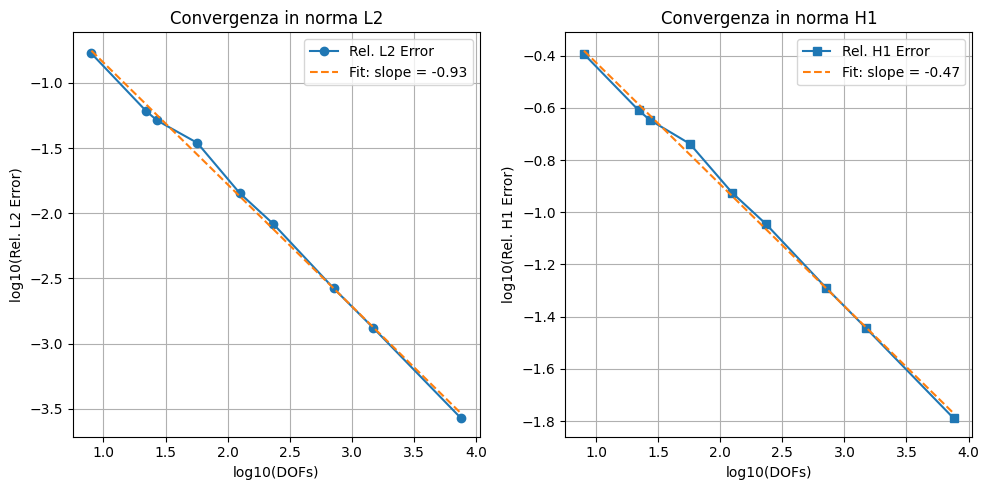

In [27]:
import matplotlib.pyplot as plt

# Supponiamo che dofs_errors sia già definito
# dofs_errors = {dofs1: [rel_L2_err1, rel_H1_err1], dofs2: [...], ...}

# Ordina per numero di DOFs
dofs_sorted = sorted(dofs_errors.keys())
log_dofs = np.log10(dofs_sorted)
rel_L2_errors = [dofs_errors[d][0] for d in dofs_sorted]
rel_H1_errors = [dofs_errors[d][1] for d in dofs_sorted]

log_rel_L2_errors = np.log10(rel_L2_errors)
log_rel_H1_errors = np.log10(rel_H1_errors)

# Fit lineare (retta) in scala log-log
coeffs_L2 = np.polyfit(log_dofs, log_rel_L2_errors, 1)
coeffs_H1 = np.polyfit(log_dofs, log_rel_H1_errors, 1)

# Stampa pendenze
print(f"Pendenza errore relativo L2: {coeffs_L2[0]:.4f}")
print(f"Pendenza errore relativo H1: {coeffs_H1[0]:.4f}")

# Plot L2
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(log_dofs, log_rel_L2_errors, 'o-', label='Rel. L2 Error')
plt.plot(log_dofs, np.polyval(coeffs_L2, log_dofs), '--', label=f'Fit: slope = {coeffs_L2[0]:.2f}')
plt.xlabel('log10(DOFs)')
plt.ylabel('log10(Rel. L2 Error)')
plt.title('Convergenza in norma L2')
plt.legend()
plt.grid(True)

# Plot H1
plt.subplot(1, 2, 2)
plt.plot(log_dofs, log_rel_H1_errors, 's-', label='Rel. H1 Error')
plt.plot(log_dofs, np.polyval(coeffs_H1, log_dofs), '--', label=f'Fit: slope = {coeffs_H1[0]:.2f}')
plt.xlabel('log10(DOFs)')
plt.ylabel('log10(Rel. H1 Error)')
plt.title('Convergenza in norma H1')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
